In [1]:

packages <- c(
    "ggplot2", 
    "dplyr", 
    "patchwork",
    "ggExtra",
    "VennDiagram"
)
for (pkg in packages) {
    suppressPackageStartupMessages(
        suppressWarnings(
            library(
                pkg,
                character.only = TRUE,
                quietly = TRUE,
                warn.conflicts = FALSE
            )
        )
    )
}
source("../../utils/r_themes.r")

In [2]:
lm_results_file_path <- file.path(
    "../results/all_features_beta_df.parquet"
)
plot_save_dir <- file.path(
    "../figures"
)
if (!dir.exists(plot_save_dir)) {
    dir.create(plot_save_dir, recursive = TRUE)
}
plot_file_path <- file.path(
    plot_save_dir,
    "lm_coefficients_colored_by_feature_type_CP_scDINO.png"
)

plot_file_path2 <- file.path(
    plot_save_dir,
    "lm_coefficients_colored_by_channel_CP_scDINO.png"
)
lm_coeff_df <- arrow::read_parquet(lm_results_file_path)
# shuffle the row order for plotting purposes
lm_coeff_df <- lm_coeff_df %>%
    dplyr::mutate(
        row_id = 1:nrow(lm_coeff_df)
    ) %>%
    dplyr::arrange(dplyr::desc(row_id)) %>%
    dplyr::select(-row_id)
head(lm_coeff_df)

beta,p_value,variate,r2,feature,Compartment,Feature_type,Channel,Channel2,featurizer_id,feature_number,Measurement,p_value_corrected
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1.389132e-03,4.027724e-36,Dose,0.5253489,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,2.560208e-35
-6.507593e-04,3.219243e-02,Cell count,0.5253489,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,5.342914e-02
1.739169e-02,1.992699e-34,Time,0.5253489,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,1.214598e-33
-8.530284e-02,1.245588e-01,const,0.5253489,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,1.767468e-01
-7.025796e-05,4.230264e-01,Dose,0.4111726,feature,scDINO,scDINO,DNA,NA,scDINO,99,scDINO,5.039855e-01
-8.053319e-04,2.668872e-03,Cell count,0.4111726,feature,scDINO,scDINO,DNA,NA,scDINO,99,scDINO,5.379193e-03


In [3]:
lm_coeff_df$log10p_value <- -log10(lm_coeff_df$p_value)
# remove the const from the variate column
lm_coeff_df <- lm_coeff_df %>%
    filter(
        !grepl("const", variate)
    )
# if the log10p is inf then set to the max value
lm_coeff_df$log10p_value[is.infinite(lm_coeff_df$log10p_value)] <- max(
    lm_coeff_df$log10p_value[!is.infinite(lm_coeff_df$log10p_value)]
)

lm_coeff_df$Feature_type <- gsub(
    "RadialDistribution",
    "Radial\nDistibution",
    lm_coeff_df$Feature_type
)
head(lm_coeff_df)

beta,p_value,variate,r2,feature,Compartment,Feature_type,Channel,Channel2,featurizer_id,feature_number,Measurement,p_value_corrected,log10p_value
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1.389132e-03,4.027724e-36,Dose,0.5253489,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,2.560208e-35,35.3949403
-6.507593e-04,3.219243e-02,Cell count,0.5253489,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,5.342914e-02,1.4922462
1.739169e-02,1.992699e-34,Time,0.5253489,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,1.214598e-33,33.7005582
-7.025796e-05,4.230264e-01,Dose,0.4111726,feature,scDINO,scDINO,DNA,NA,scDINO,99,scDINO,5.039855e-01,0.3736325
-8.053319e-04,2.668872e-03,Cell count,0.4111726,feature,scDINO,scDINO,DNA,NA,scDINO,99,scDINO,5.379193e-03,2.5736723
1.691805e-02,3.091312e-40,Time,0.4111726,feature,scDINO,scDINO,DNA,NA,scDINO,99,scDINO,2.184963e-39,39.5098572


In [4]:
print(paste0("Total number of models trained: ", nrow(lm_coeff_df)/n_distinct(lm_coeff_df$variate)))

[1] "Total number of models trained: 2336"


Warning message:
“Duplicated `override.aes` is ignored.”
Warning message:
“Duplicated `override.aes` is ignored.”


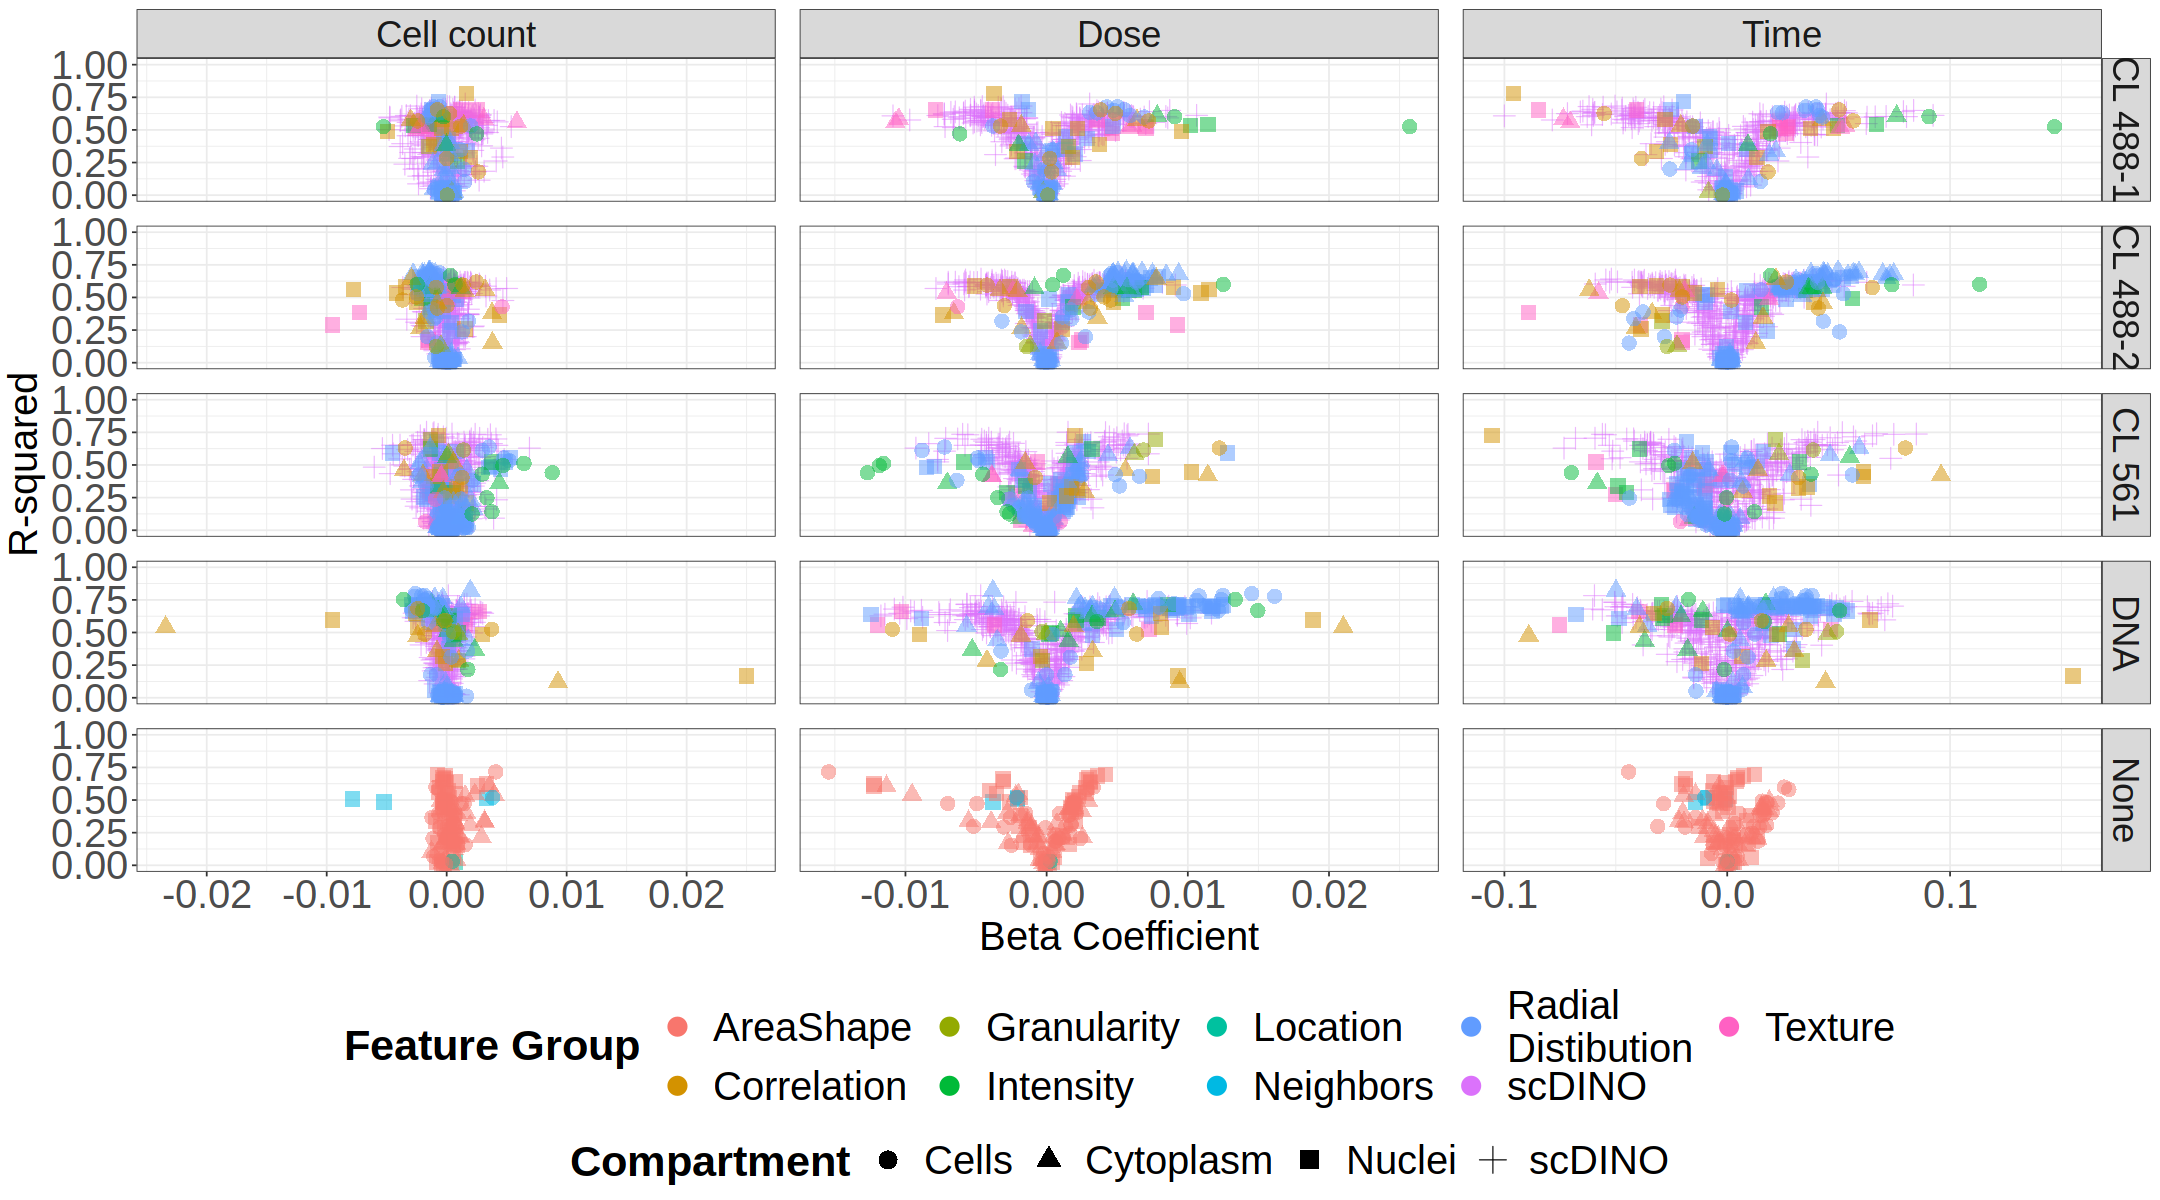

In [5]:
width <- 18
height <- 10
options(repr.plot.width = width, repr.plot.height = height)
lm_coeff_plot <- (
    ggplot(lm_coeff_df, aes(
        x = beta, 
        y = r2, 
        fill = Feature_type, 
        )
    )
    + geom_point(
        aes(
            color = Feature_type,
            shape = Compartment
        ),
        alpha = 0.5,
        stroke = 0.5,
        size = 4
    )
    + labs(
        x = "Beta Coefficient",
        y = "R-squared",
    )
    + plot_themes
    + guides(
        fill = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Feature Group",
            # title position
            # title.position = "top",
            # title.hjust = 0.5,
            title.theme = element_text(face = "bold", size = font_size + 2),
        ),
        color = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Feature Group",
            # title position
            # title.position = "top",
            # title.hjust = 0.5,
            title.theme = element_text(face = "bold", size = font_size + 2),

        ),
    
        shape = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Compartment",
            # title.position = "top",
            # title.hjust = 0.5,
            title.theme = element_text(face = "bold", size = font_size + 2),


        )
    )
    + ylim(0,1)
    + facet_grid(
        Channel ~ variate,
        scales = "free",

    )

    + theme(
        panel.spacing = unit(1, "lines"),

        legend.box = "vertical",  # Stack legends vertically
        # legend.box.just = "left"  # Align legends to the left
    )
)
ggsave(
    filename = plot_file_path,
    plot = lm_coeff_plot,
    device = "png",
    width = width,
    height = height,
    dpi = 600,
    units = "in",
)
lm_coeff_plot     


Warning message:
“Duplicated `override.aes` is ignored.”
Warning message:
“Duplicated `override.aes` is ignored.”


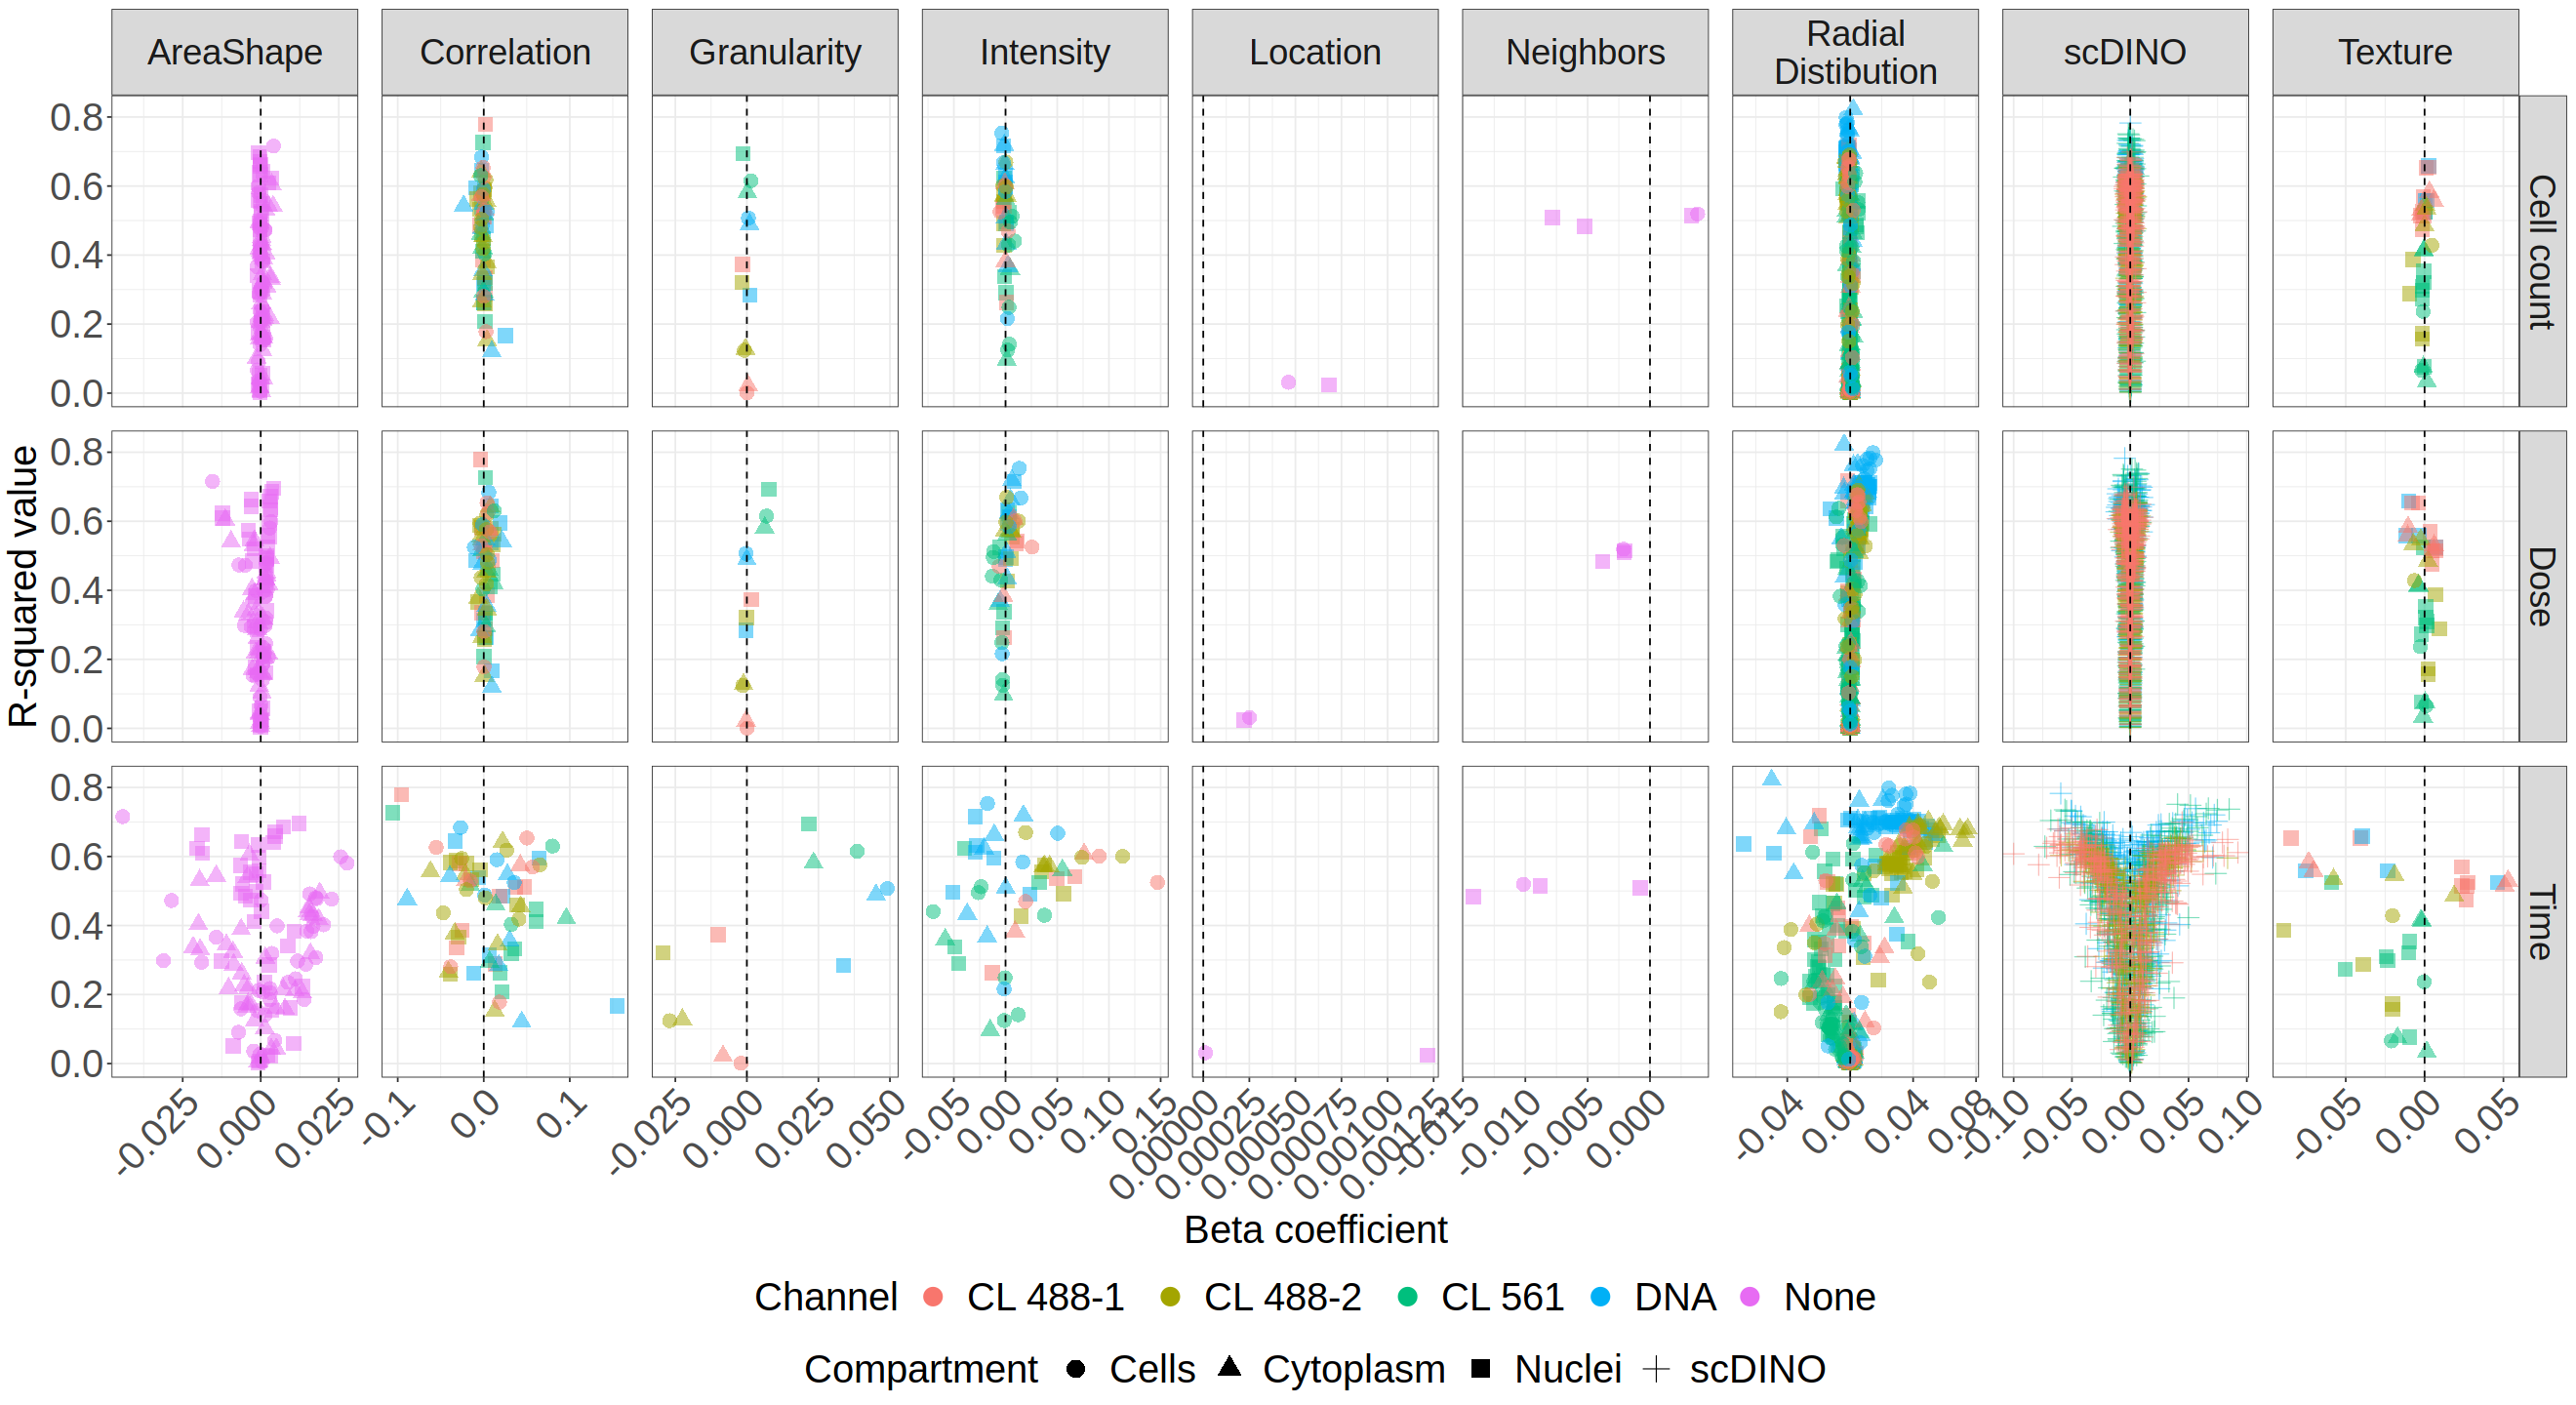

In [6]:
width <- 22
height <- 12
options(repr.plot.width = width, repr.plot.height = height)
lm_coeff_plot2 <- (
    ggplot(lm_coeff_df, aes(
        x = beta, 
        y = r2, 
        fill = Channel, 
        )
    )
    + geom_point(
        aes(
            color = Channel,
            shape = Compartment
        ),
        alpha = 0.5,
        stroke = 0.5,
        size = 4
    )
    + labs(
        x = "Beta coefficient",
        y = "R-squared value"
    )
    + plot_themes
    + guides(
        fill = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Channel"
        ),
        color = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Channel"
        ),
    
        shape = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Compartment"
        )
    )
    + facet_grid(
        variate ~ Feature_type,
        scales = "free",

    )
    + geom_vline(
        xintercept = 0,
        linetype = "dashed",
    )
        + theme(
        panel.spacing = unit(1, "lines"),  # Adjust spacing between facets
        # x ticks rotation
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)
        
    )

    + theme(
        panel.spacing = unit(1, "lines"),

        legend.box = "vertical",  # Stack legends vertically
        # legend.box.just = "left"  # Align legends to the left
    )

)
ggsave(
    filename = plot_file_path2,
    plot = lm_coeff_plot2,
    device = "png",
    width = width,
    height = height,
    dpi = 600,
    units = "in",
)
lm_coeff_plot2   


## Get feature overlaps for CP and scDINO

In [7]:
# set the feature to feature + feature_number if scDINO in featurizer id
lm_coeff_df %>%
    mutate(
        feature = ifelse(
            grepl("scDINO", featurizer_id),
            paste0(feature, "_", feature_number),
            feature
        )
    ) -> lm_coeff_df


In [8]:
# find the intersection of features that are significant for both variates
cell_count_sig_features <- lm_coeff_df %>%
    dplyr::filter(
        variate == "Cell count" & p_value_corrected < 0.05
    ) %>%
    dplyr::pull(feature)
dose_sig_features <- lm_coeff_df %>%
    dplyr::filter(
        variate == "Dose" & p_value_corrected < 0.05
    ) %>%
    dplyr::pull(feature)
time_sig_features <- lm_coeff_df %>%
    dplyr::filter(
        variate == "Time" & p_value_corrected < 0.05
    ) %>%
    dplyr::pull(feature)

# print the number of features in each set
total_features <- n_distinct(lm_coeff_df$feature)
print(
    paste0(
        "Number of significant features for Cell count: ", 
        n_distinct(cell_count_sig_features),
        " Percent of total: ",
        round(n_distinct(cell_count_sig_features)/total_features*100, 2), "%"
    )
)
print(
    paste0(
        "Number of significant features for Dose: ", 
        n_distinct(dose_sig_features),
        " Percent of total: ",
        round(n_distinct(dose_sig_features)/total_features*100, 2), "%"
))
print(
    paste0(
        "Number of significant features for Time: ", 
        n_distinct(time_sig_features),
        " Percent of total: ",
        round(n_distinct(time_sig_features)/total_features*100, 2), "%"
))
print(total_features)

[1] "Number of significant features for Cell count: 513 Percent of total: 43.33%"
[1] "Number of significant features for Dose: 958 Percent of total: 80.91%"
[1] "Number of significant features for Time: 889 Percent of total: 75.08%"
[1] 1184


pdf 
  2

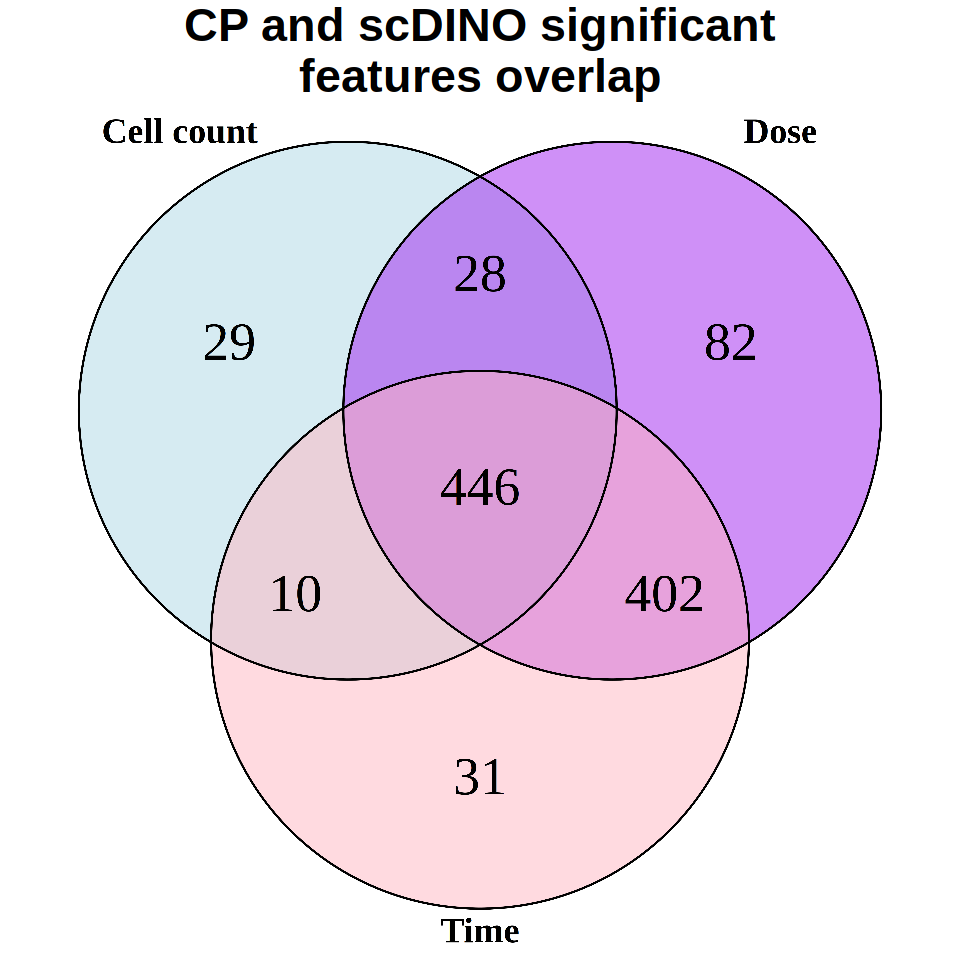

In [9]:
# venn diagram of the three sets
width <- 8
height <- 8
options(repr.plot.width = width, repr.plot.height = height)
venn.plot_CP_scDINO <- venn.diagram(
    x = list(
        `Cell count` = cell_count_sig_features,
        `Dose` = dose_sig_features,
        `Time` = time_sig_features
    ),
    filename = NULL,
    fill = c("lightblue", "purple", "lightpink"),
    alpha = 0.5,    
    cex = 3,
    cat.cex = 2,
    cat.fontface = "bold",
    main.cex = 2,
    # shift the names in
    cat.pos = c(-30, 30, 180),
)
# save the venn diagram
venn_file_path <- file.path(
    plot_save_dir,
    "venn_diagram_significant_features_CP_scDINO.png"
)
png(venn_file_path, width = width, height = height, res = 600, units = "in")
grid.draw(venn.plot_CP_scDINO)
dev.off()
venn.plot_CP_scDINO = png::readPNG(venn_file_path)
# plot the montage image to a ggplot object
venn.plot_CP_scDINO <- (
    ggplot()
    + annotation_custom(
        rasterGrob(venn.plot_CP_scDINO, interpolate = TRUE),
        xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf
    )
    + theme_void()
    + ggtitle(
        "CP and scDINO significant\nfeatures overlap"
    )
    + theme(
        plot.title = element_text(hjust = 0.5, size = font_size + 4, face = "bold")
    )
)
venn.plot_CP_scDINO

## Just for CP

In [10]:
lm_coeff_df <- lm_coeff_df %>%
    dplyr::filter(featurizer_id != "scDINO")

In [11]:
# find the intersection of features that are significant for both variates
cell_count_sig_features <- lm_coeff_df %>%
    dplyr::filter(
        variate == "Cell count" & p_value_corrected < 0.05
    ) %>%
    dplyr::pull(feature)
dose_sig_features <- lm_coeff_df %>%
    dplyr::filter(
        variate == "Dose" & p_value_corrected < 0.05
    ) %>%
    dplyr::pull(feature)
time_sig_features <- lm_coeff_df %>%
    dplyr::filter(
        variate == "Time" & p_value_corrected < 0.05
    ) %>%
    dplyr::pull(feature)

# print the number of features in each set
total_features <- n_distinct(lm_coeff_df$feature)
print(
    paste0(
        "Number of significant features for Cell count: ", 
        n_distinct(cell_count_sig_features),
        " Percent of total: ",
        round(n_distinct(cell_count_sig_features)/total_features*100, 2), "%"
    )
)
print(
    paste0(
        "Number of significant features for Dose: ", 
        n_distinct(dose_sig_features),
        " Percent of total: ",
        round(n_distinct(dose_sig_features)/total_features*100, 2), "%"
))
print(
    paste0(
        "Number of significant features for Time: ", 
        n_distinct(time_sig_features),
        " Percent of total: ",
        round(n_distinct(time_sig_features)/total_features*100, 2), "%"
))


[1] "Number of significant features for Cell count: 178 Percent of total: 22.25%"
[1] "Number of significant features for Dose: 574 Percent of total: 71.75%"
[1] "Number of significant features for Time: 505 Percent of total: 63.12%"


pdf 
  2

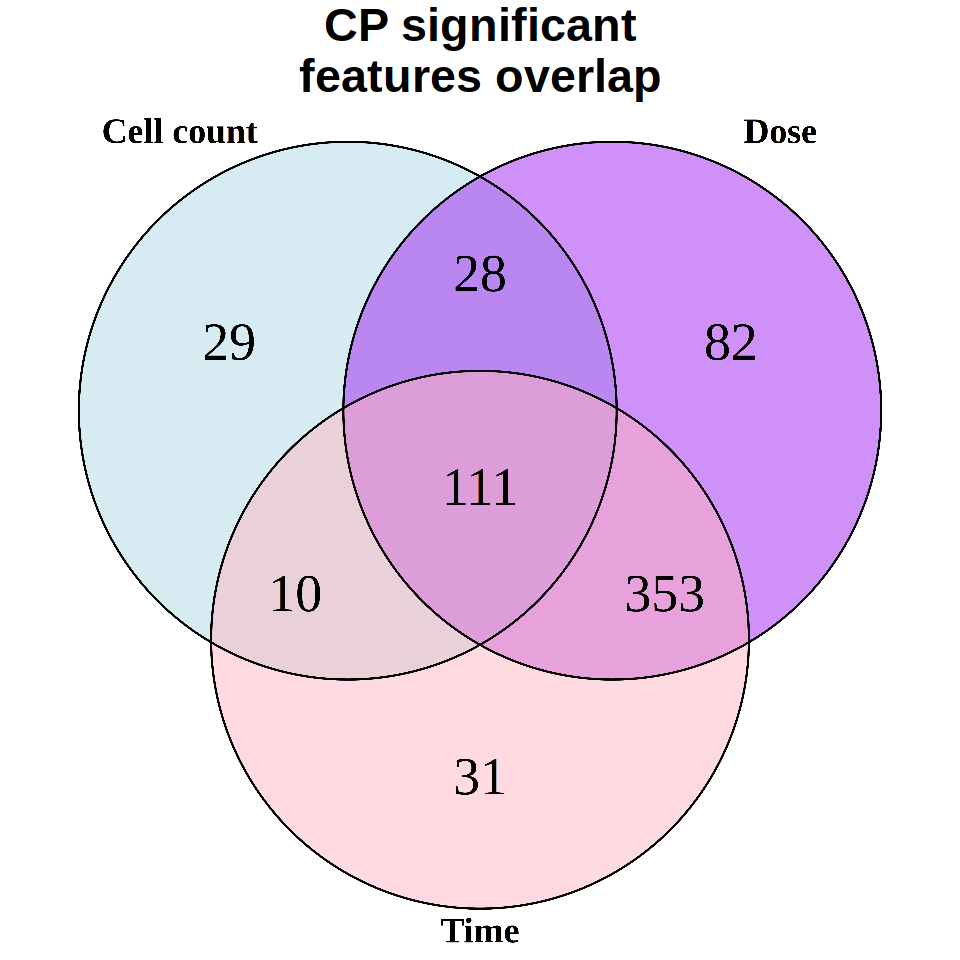

In [12]:
# venn diagram of the three sets
width <- 8
height <- 8
options(repr.plot.width = width, repr.plot.height = height)
venn.plot <- venn.diagram(
    x = list(
        `Cell count` = cell_count_sig_features,
        `Dose` = dose_sig_features,
        `Time` = time_sig_features
    ),
    filename = NULL,
    fill = c("lightblue", "purple", "lightpink"),
    alpha = 0.5,    
    cex = 3,
    cat.cex = 2,
    cat.fontface = "bold",
    main.cex = 2,
    # shift the names in
    cat.pos = c(-30, 30, 180),
)
# save the venn diagram
venn_file_path <- file.path(
    plot_save_dir,
    "venn_diagram_significant_features_CP.png"
)
png(venn_file_path, width = width, height = height, res = 600, units = "in")
grid.draw(venn.plot)
dev.off()
venn.plot_CP = png::readPNG(venn_file_path)
# plot the montage image to a ggplot object
venn.plot_CP <- (
    ggplot()
    + annotation_custom(
        rasterGrob(venn.plot_CP, interpolate = TRUE),
        xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf
    )
    + theme_void()
    + ggtitle(
        "CP significant\nfeatures overlap"
    )
    + theme(
        plot.title = element_text(hjust = 0.5, size = font_size + 4, face = "bold")
    )
)
venn.plot_CP

## Final Figure for both CP and scDINO

Warning message:
“Duplicated `override.aes` is ignored.”


pdf 
  2

Warning message:
“Duplicated `override.aes` is ignored.”


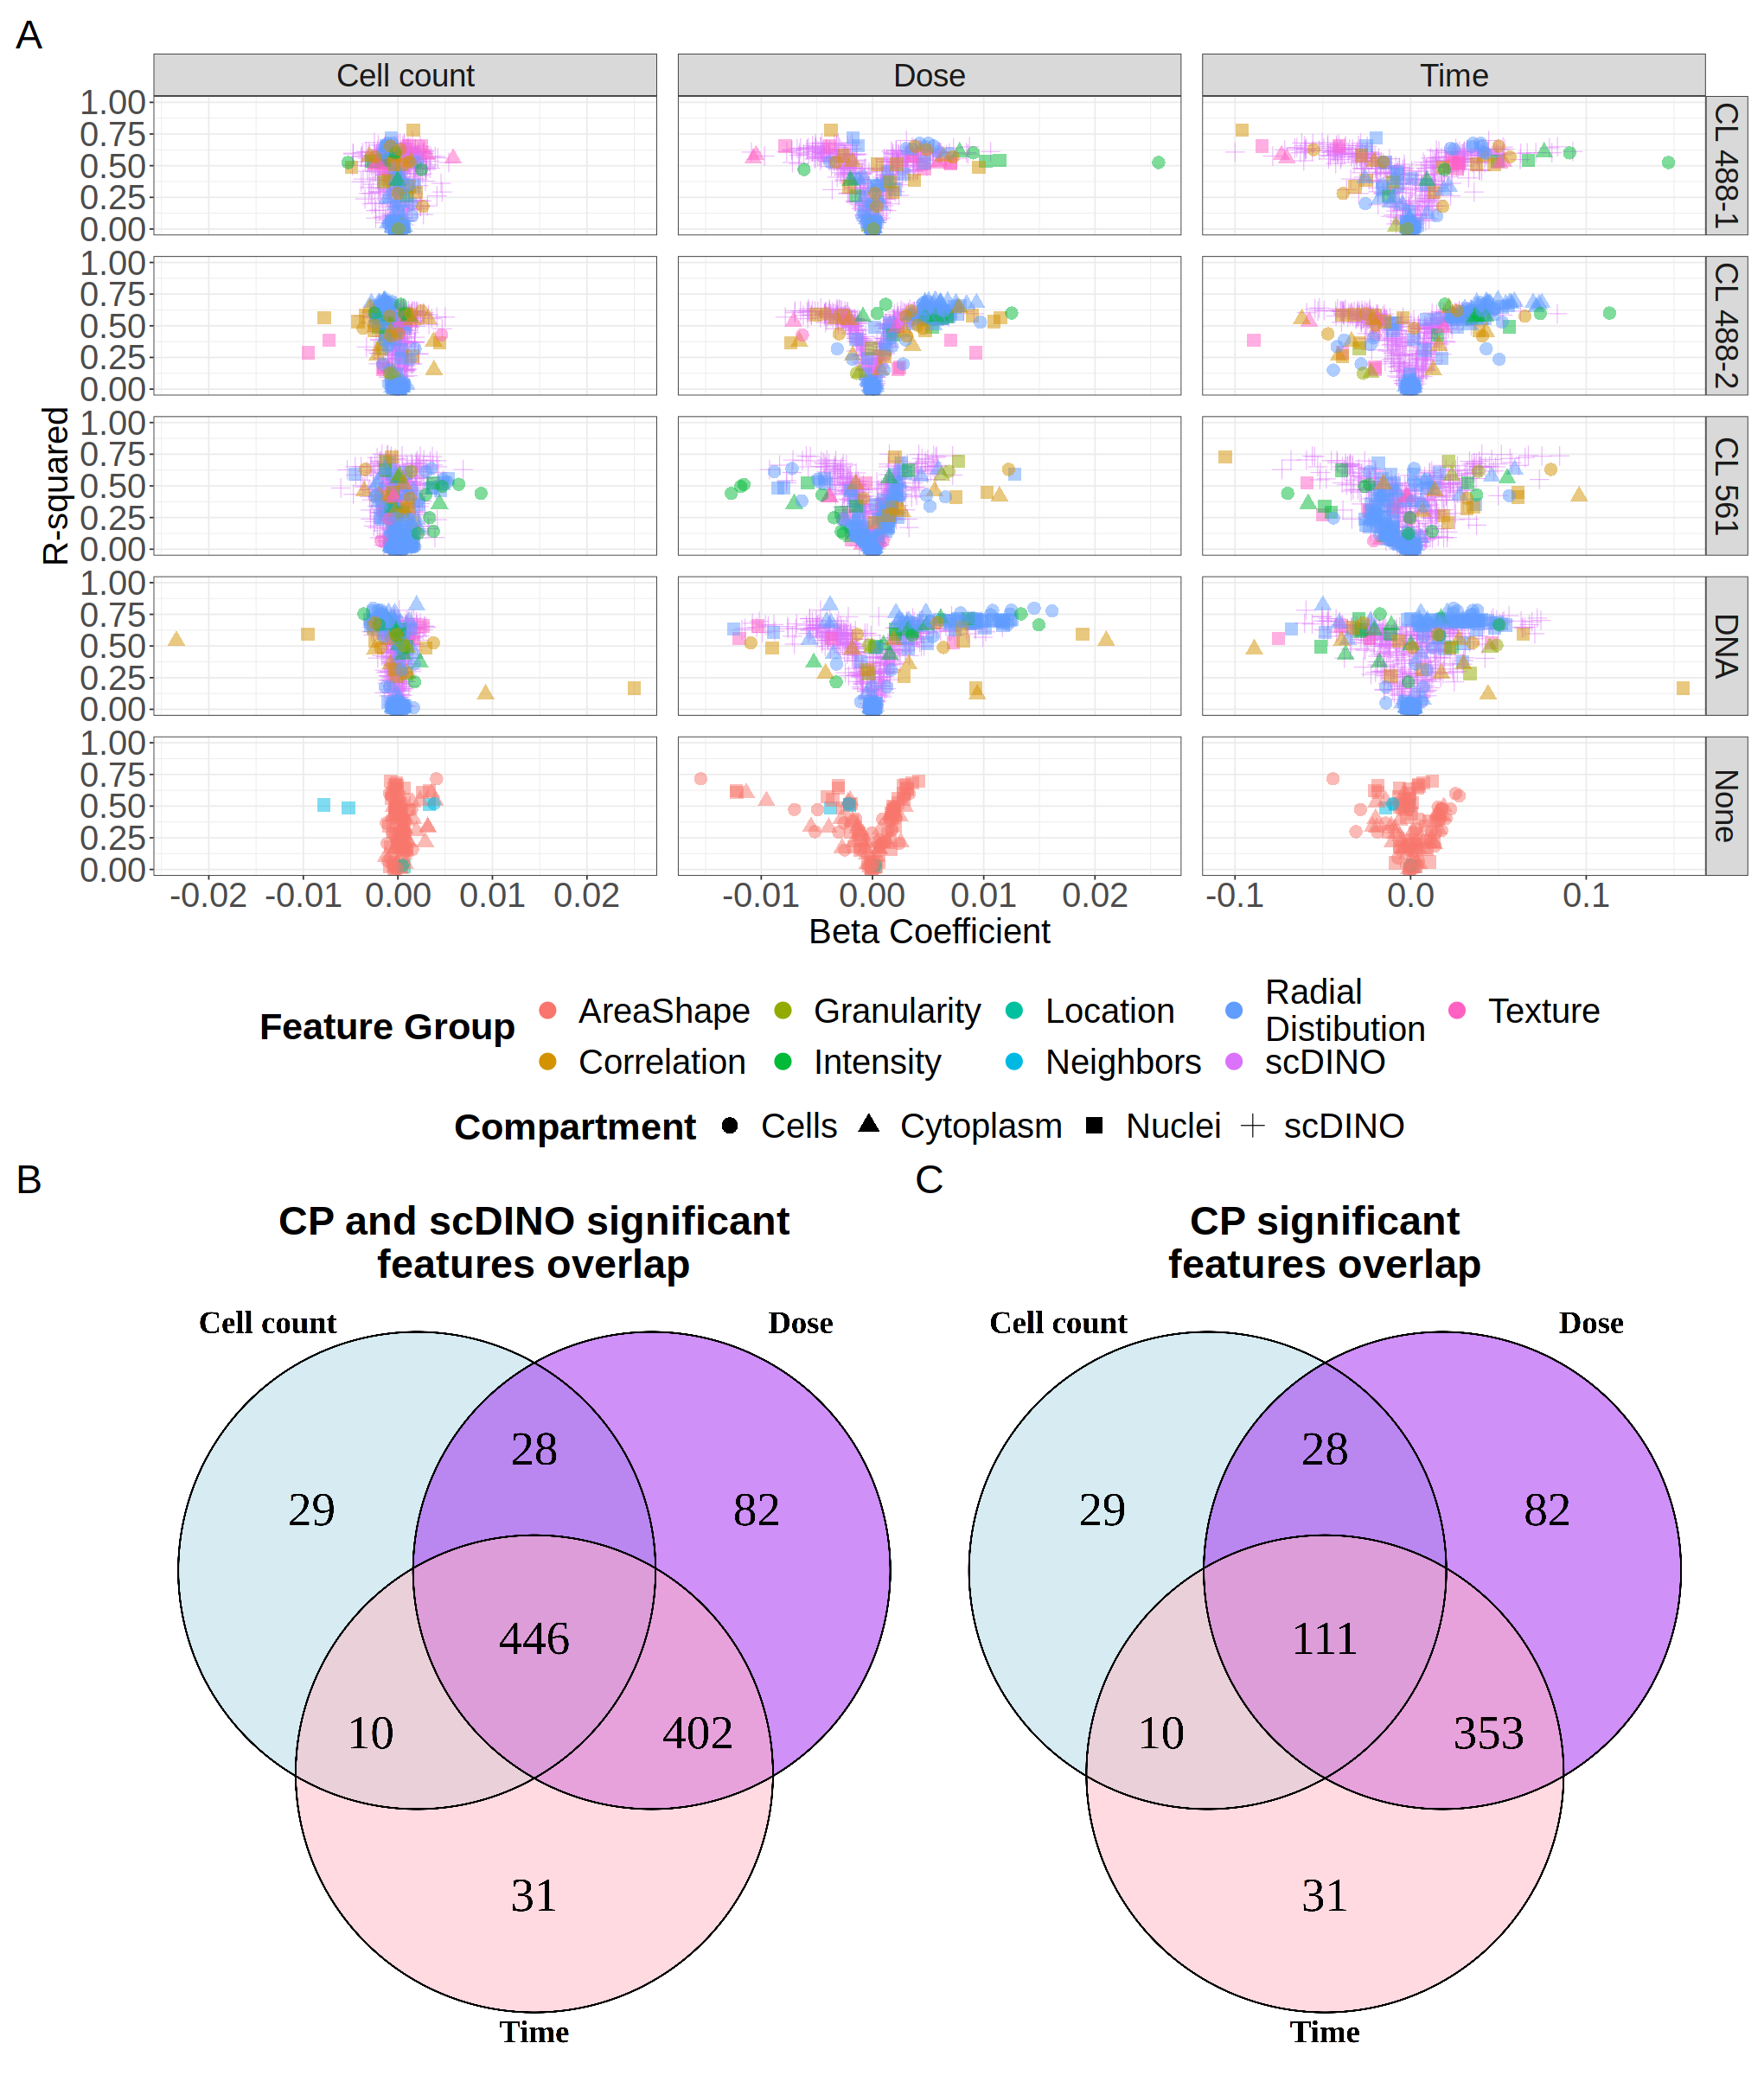

In [13]:
width <- 17
height <- 20
options(repr.plot.width = width, repr.plot.height = height)

layout <- "
AA
BC
"

final_plot <- (
    lm_coeff_plot
    + venn.plot_CP_scDINO
    + venn.plot_CP
    + plot_layout(
        design = layout
    )
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 28))

)
plot_file_path <- file.path(
    plot_save_dir,
    "final_figure_lm_coefficients_and_venn_diagrams_CP_scDINO.png"
)
png(
   filename = plot_file_path,
   width = width,
   height = height,
   units = "in",
   res = 600,
)
final_plot
dev.off()
final_plot